# Find wet vegetation (daily masking)

- Use wofs to mask daily imagery
- Calculate TCG and TCW
- Find daily wet vegetation
- Summarise monthly wet vegetation

### Import

In [49]:
import sys
import datacube
from datacube.helpers import write_geotiff
from datacube.utils import cog
from datetime import datetime
from datetime import timedelta
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datacube.storage import masking

sys.path.append("Scripts")
from dea_datahandling import load_ard
from dea_plotting import rgb
from dea_plotting import display_map
from dea_bandindices import calculate_indices
from dea_datahandling import wofs_fuser
from dea_dask import create_local_dask_cluster

In [50]:
create_local_dask_cluster()

/env/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34247 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:37219 Dashboard: /user/gabrielleh/proxy/34247/status,Cluster Workers: 1 Cores: 8 Memory: 61.42 GB


In [51]:
dc = datacube.Datacube(app="Sentinel_2_burn_ratio")

### Get coordinates from tile
- Too big to load many images

In [52]:
tile = '11_-40'
# Define funciton to get tile bounds
def get_tile_bounds(tile):
    x, y = tile.split('_')
    minx = int(x) * 100000
    miny = int(y) * 100000
    maxx = minx + 100000
    maxy = miny + 100000
    return {'minx': minx, 'miny': miny, 'maxx': maxx, 'maxy': maxy}
bounds = get_tile_bounds(tile)
x=(bounds['minx'],bounds['maxx'])
y=(bounds['miny'],bounds['maxy'])

### Use coordinates to locate small area of interest

In [124]:
# Set the central latitude and longitude
# #Barmah
# central_lat = -35.858473
# central_lon = 145.023703


# #GKP
# central_lat = -35.847129
# central_lon = 144.386452

# Barren Grounds
# central_lat = -34.709078
# central_lon = 150.715434

# # Mac Marshes
# central_lat = -30.698510
# central_lon = 147.534219

# # # Yorke
# central_lat = -34.211294
# central_lon =  137.774868

# # Arafura
# central_lat = -12.562990
# central_lon =  135.035205

# # Ayr
# central_lat = -19.371645
# central_lon =  146.922991

# # Burdekin
# central_lat = -19.926378 
# central_lon =  145.626075

# # Tas
# central_lat = -42.019291
# central_lon =  146.214005

# Syd
central_lat = -34.558100
central_lon =  150.646049


# Set the buffer to load around the central coordinates
buffer = 0.5

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

display_map(x=study_area_lon, y=study_area_lat, crs='EPSG:4326', margin=-0.2)

/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/env/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: h

### Load WOFLS

In [125]:
# # Create a reusable query
# query = {
#     "x": study_area_lon,
#     "y": study_area_lat,
#     "time": ('2016-01-01', '2016-12-31'),
#     "output_crs": "EPSG:3577",
#     "crs":'EPSG:4326',
#     "resolution": (-25, 25),
#     "group_by": "solar_day",
#     "fuse_func": wofs_fuser,
# }


# # Load the data from the datacube
# wofls = dc.load(product="wofs_albers", 
#                 dask_chunks={"time": 1, "x": 3000, "y": 3000}, 
#                 **query)


In [126]:
# wofls

In [127]:
# Plot the loaded WOFLs
# wofls.water.plot(col="time", col_wrap=5)
# plt.show()

### Load surface reflectance

In [128]:
# list(dc.list_products()['name'])

In [129]:
# Load a fractional cover (FC) tile to match the WOFLs data by using 'like'
# data = dc.load(product="ga_ls8c_ard_3", group_by="solar_day", 
#                measurements=['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2'], 
#                dask_chunks={"time": 1, "x": 3000, "y": 3000}, 
#                like=wofls)

# Create a reusable query
query = {
    "x": study_area_lon,
    "y": study_area_lat,
    "time": ('2016-01-01', '2016-12-31'),
    "output_crs": "EPSG:3577",
    "crs":'EPSG:4326',
    "resolution": (-30, 30),
#     "group_by": "solar_day",
#     "fuse_func": wofs_fuser,
}


data = load_ard(dc=dc,
#                 min_gooddata=0.1,
                products=["ga_ls8c_ard_3"], 
                group_by="solar_day", 
                measurements=['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2'], 
                dask_chunks={"time": 1, "x": 3000, "y": 3000}, 
                **query)
# data

Loading ga_ls8c_ard_3 data
    Applying pixel quality/cloud mask
    Applying invalid data mask
    Applying contiguity mask
Combining and sorting data
    Returning 46 observations as a dask array


In [130]:
# list(dc.list_products()['name'])

In [131]:
# mang = dc.load(product='mangrove_cover',**query)

In [132]:
# data

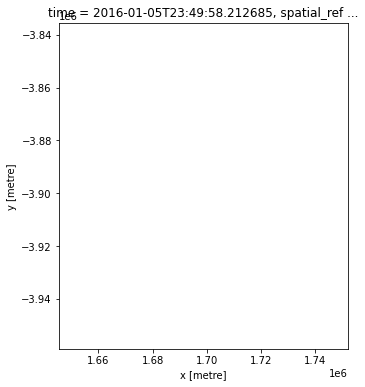

In [133]:
# data.nbart_red.plot(col="time", col_wrap=5)
# plt.show()

rgb(data.isel(time=0))

### Make cloud mask

In [134]:
# # Make cloud free data
# def cloud_free(data,wofls):
#     # Remove milliseconds 
#     data['time'] = data.indexes['time'].normalize()
#     wofls['time'] = wofls.indexes['time'].normalize()

#     # Find duplicates
#     wofls_dates = wofls['time'].isin(data['time'].values)

#     # Only select NRT that is not duplicated in ARD
#     wofls_sel = wofls.sel(time=wofls_dates)
#     # wofls_sel

#     # Removing clouds and their shadows
#     clear = {"cloud_shadow": False, "cloud": False, "nodata":False, "noncontiguous": False}

#     cloudfree = masking.make_mask(wofls_sel, **clear)
#     cloudfree_data = data.where(cloudfree.water == True)
#     # cloudfree_data.nbart_red.plot()
#     # plt.show()
#     return cloudfree_data

In [135]:
# cloudfree_data = cloud_free(data,wofls)

### Calculate TCG and TCW

In [136]:
cloudfree_data = data

In [137]:
cloudfree_data = calculate_indices( cloudfree_data, 
                          index='TCW', 
                          collection='ga_ls_3', 
                          normalise=False,
                          drop=False)

cloudfree_data = calculate_indices( cloudfree_data, 
                          index='TCG', 
                          collection='ga_ls_3', 
                          normalise=False,
                          drop=False)

Scripts/dea_bandindices.py:268: UserWarning: 
A coefficient-based index ('TCW') normally applied to surface reflectance values in the 
0.0-1.0 range was applied to values in the 0-10000 range. This can produce unexpected results; 
if required, resolve this by setting `normalise=True`
  warnings.warn(f"\nA coefficient-based index ('{index}') normally "
Scripts/dea_bandindices.py:268: UserWarning: 
A coefficient-based index ('TCG') normally applied to surface reflectance values in the 
0.0-1.0 range was applied to values in the 0-10000 range. This can produce unexpected results; 
if required, resolve this by setting `normalise=True`
  warnings.warn(f"\nA coefficient-based index ('{index}') normally "


In [138]:
# (cloudfree_data.TCG>1000).plot(col="time", cmap='Greens',col_wrap=5)
# plt.show()

In [139]:
# (cloudfree_data.TCW>-350).plot(col="time", cmap='Blues',col_wrap=5)
# plt.show()

### Calculate daily wet vegetation

In [140]:
tcg_thres = 1000
tcw_thres = -350

green = cloudfree_data.TCG > tcg_thres
wet = cloudfree_data.TCW > tcw_thres
not_green= wet.where(green != 1,0,0)

not_green = not_green.groupby('time.month').max(dim='time')  
# not_green = np.where(green.TCG != 1, wet.TCW, 0)
# not_green = (green.TCG != 1) & wet.TCW #green.TCG & wet.TCW
not_green

<xarray.DataArray 'TCW' (month: 12, y: 4117, x: 3556)>
dask.array<stack, shape=(12, 4117, 3556), dtype=int64, chunksize=(1, 3000, 3000), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int32 3577
  * x            (x) float64 1.645e+06 1.645e+06 ... 1.752e+06 1.752e+06
  * y            (y) float64 -3.835e+06 -3.835e+06 ... -3.959e+06 -3.959e+06
  * month        (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [141]:
# not_green.plot(col="month", cmap='Blues',col_wrap=5)
# plt.show()

### Plot image
- Save out image

In [142]:
# not_green.plot.imshow(col="month", cmap='Blues', col_wrap=4, size=4,interpolation='gaussian')
# fig = not_green.plot(col="month", cmap='Blues', col_wrap=4, size=4)
# plt.savefig('foo.png')

### Annual statistics

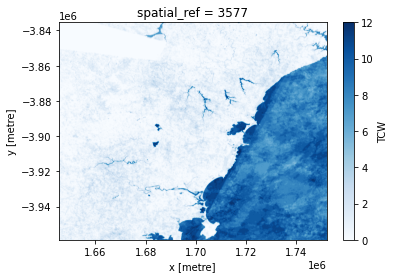

In [143]:
freq = not_green.sum(dim='month')
freq.plot.imshow(cmap='Blues',interpolation='gaussian')

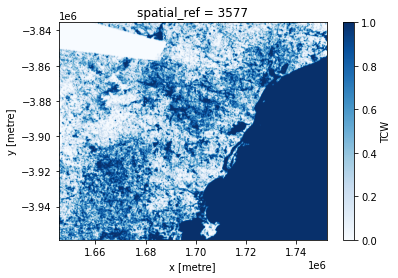

In [144]:
year_max = (freq >= 1)
year_max.plot.imshow(cmap='Blues',interpolation='gaussian')

In [74]:
# year_max.astype('int8')

In [75]:
cog.write_cog(freq.astype('int8'),f'freq_mac_marsh_TCG_{tcg_thres}_TCW_{tcw_thres}.tif').compute()
cog.write_cog(year_max.astype('int8'),f'max_mac_marsh_TCG_{tcg_thres}_TCW_{tcw_thres}.tif').compute()

PosixPath('max_mac_marsh_TCG_1000_TCW_-350.tif')

In [76]:
# pwd

In [77]:
# import copy
# from itertools import groupby

In [78]:
# ### Consecutive count
# def consecutive_count(water_numpy, consecutive_numpy, required_consecutive, consec_msk_val=1):
#     '''
#     function to get consective count of water (1) for each pixel across the time series

#     :param numpy.array water_numpy: 3-D array of tv[z,y,x]
#     :param numpy.array consecutive_numpy: bool output array for water (1) and not water (0)
#     :param float required_consecutive: how many consectutive 1's to be classified as water?
#     :param float consec_msk_val: what value to calculcate consectutives on
#            default is water (1)     
#     '''

#     for y in range(water_numpy.shape[1]):
#         for x in range(water_numpy.shape[2]):
#             # If all the values are nan then just set output to nan and carry on
#             pixel = water_numpy[:,y,x]

#             if np.all(np.isnan(pixel)):
#                 consecutive_numpy[y,x] = np.nan
#                 continue            

#             # Get counts of consecutive water classifications
#             counts = [len(list(group)) for label, group in groupby(pixel[(~np.isnan(pixel))]) if label == 1]

#             if not counts:
#                 consecutive_numpy[y,x] = 0
#             elif max(counts) >= required_consecutive:
#                 consecutive_numpy[y,x] = 1
#             else:
#                 consecutive_numpy[y,x] = 0

#     return consecutive_numpy


In [79]:
# # Calculate TCW
# data = calculate_indices(data,
#                         index='TCW', 
#                         collection='ga_ls_3',
#                         drop=False,
#                         normalise=False)

# # Calculate TCW
# data = calculate_indices(data,
#                         index='TCG', 
#                         collection='ga_ls_3',
#                         drop=False,
#                         normalise=False)

# # Set thresholds
# tcg_thres = 1000
# tcw_thres = -600

# # Apply thresholds
# green = data.TCG > tcg_thres
# wet = (data.TCW > tcw_thres) & (data.TCW < 0) # wet but not open water
# wet_veg = wet.where(green != 1,0,0)

# # Calculate monthly maximum
# wet_veg_month = wet_veg.groupby('time.month').max(dim='time')  

# # Calculate annual frequency
# wet_veg_freq = wet_veg_month.sum(dim='month')

# # Calculate annual maximum extent
# # Require that wet vegetation was detected more than once
# wet_veg_max = (wet_veg_freq > 1)

# # # Make empty monthly array
# # watersea = copy.deepcopy(wet_veg_max)
# # watersea.values = np.zeros_like(wet_veg_max, dtype='float64')
# # print('watersea',watersea)


In [80]:
# # Get ready for consecutive count
# wet_numpy = wet_veg_month.values
# empty_numpy = watersea.values

# # Required consecutive
# required_consecutive = 1

# # Calculate consecutive counts
# consec = consecutive_count(wet_numpy, empty_numpy, required_consecutive)

# # Create new data array with sampe dimensions as original
# wet_summary = xr.DataArray(consec, coords=wet_veg_max.coords, dims=wet_veg_max.dims)

# print(wet_summary)

In [81]:
# wet_summary.plot.imshow(interpolation="gaussian")

In [82]:
# wet_veg_max.plot.imshow(interpolation="gaussian")